In [1]:
!nvidia-smi

Sun Feb 20 12:45:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/Colorization/celeba-dataset.zip" "/content/"

In [ ]:
!unzip *.zip && rm -rf *.zip

#ImageDataGenerator

In [12]:
import tensorflow as tf
import numpy as np
import os
import cv2

class ColorizationAutoEncoderDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, paths, SEED_PATH,
                 batch_size,
                 input_size=(128, 128, 3)):
        self.df = paths.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.PATH = SEED_PATH
        
        self.n = len(self.df)
        self.m = 0
        self.max = self.__len__()
    
    def __len__(self):
        return int(len(self.df) / float(self.batch_size))
    
    def __get_X(self, path, target_size):
        img = cv2.imread(path, 0)
        img = cv2.resize(img, (target_size[0], target_size[1]))
        img = img.astype('float32') / 255.0
        image_arr = tf.keras.preprocessing.image.img_to_array(img)
        return image_arr

    def __get_Y(self, path, target_size):
        img = cv2.imread(path, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (target_size[0], target_size[1]))
        img = img.astype('float32') / 255.0
        image_arr = tf.keras.preprocessing.image.img_to_array(img)
        return image_arr
    
    def __get_X_data(self, batches):
        # Generates data containing batch_size samples
        X_batch = np.asarray([self.__get_X(x, self.input_size) for x in batches])
        return X_batch

    def __get_Y_data(self, batches):
        # Generates data containing batch_size samples
        Y_batch = np.asarray([self.__get_Y(x, self.input_size) for x in batches])
        return Y_batch

    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        __batches = [os.path.join(self.PATH, img) for img in batches]
        X = self.__get_X_data(__batches)
        Y = self.__get_Y_data(__batches)
        return X, Y

    def __next__(self):
        if self.m >= self.max:
            self.m = 0
        x, y = self.__getitem__(self.m)
        self.m += 1
        return x, y

In [7]:
EPOCHS = 1000
BATCH_SIZE = 64
IMAGE_SHAPE = (128, 128, 3)

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("/content/img_align_celeba/", output="/content/output", seed=1337, ratio=(.8, 0.15,0.05)) 

In [36]:
TRAIN_IMAGES_PATH = "/content/output/train/img_align_celeba"
train_images = os.listdir(TRAIN_IMAGES_PATH)[:60000]
train_generator = ColorizationAutoEncoderDataGenerator(train_images, TRAIN_IMAGES_PATH, batch_size=BATCH_SIZE, input_size=IMAGE_SHAPE)

In [38]:
TEST_IMAGES_PATH = "/content/output/test/img_align_celeba"
test_images = os.listdir(TEST_IMAGES_PATH)
test_generator = ColorizationAutoEncoderDataGenerator(test_images, TEST_IMAGES_PATH, batch_size=BATCH_SIZE, input_size=IMAGE_SHAPE)

In [37]:
train_generator.__len__()

937

In [39]:
test_generator.__len__()

158

In [40]:
import matplotlib.pyplot as plt

# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color.reshape((128, 128, 3)))
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale.reshape((128, 128)), cmap="gray")
   
    plt.show()

In [41]:
gray_images, color_images = next(train_generator)

In [42]:
gray_images.shape

(64, 128, 128, 1)

In [43]:
color_images.shape

(64, 128, 128, 3)

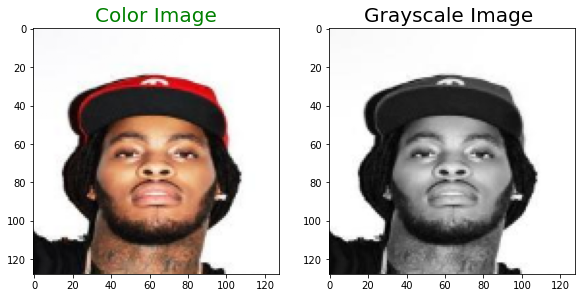

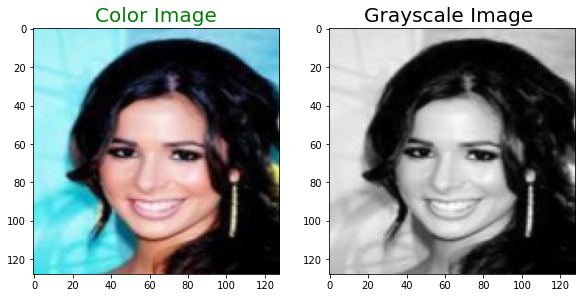

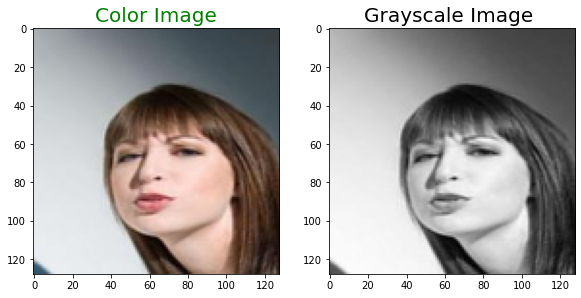

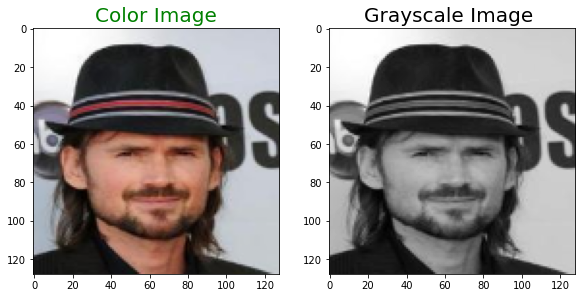

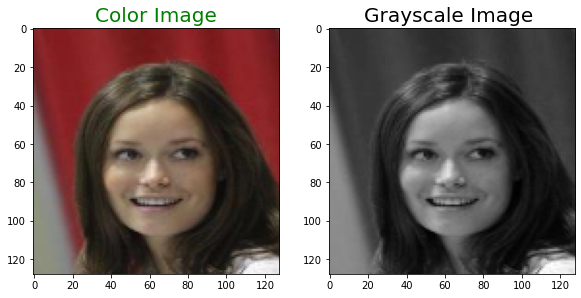

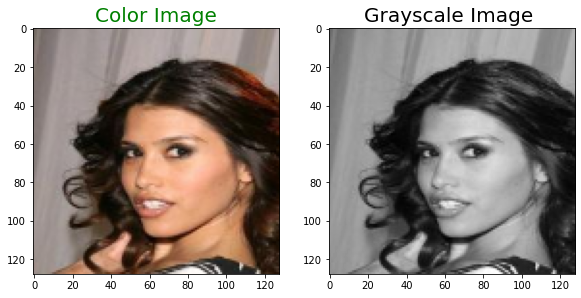

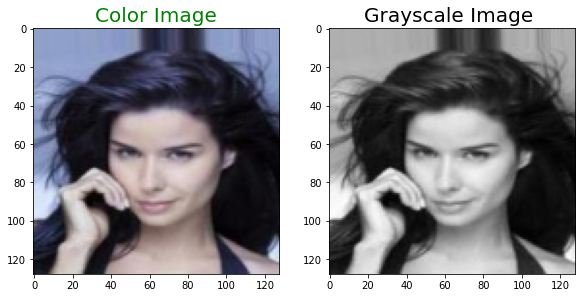

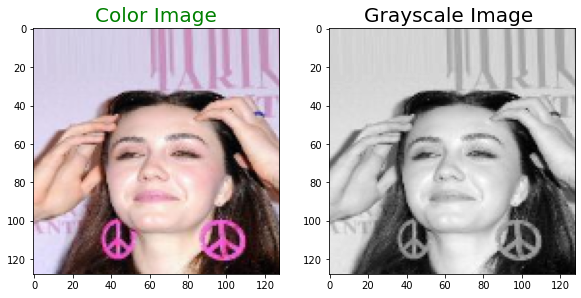

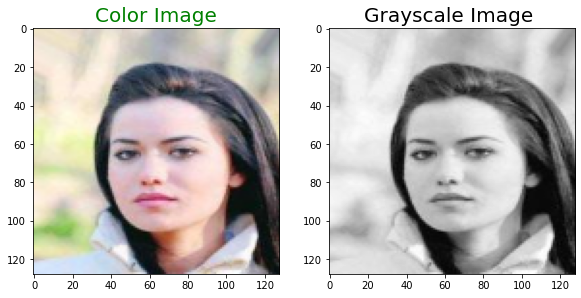

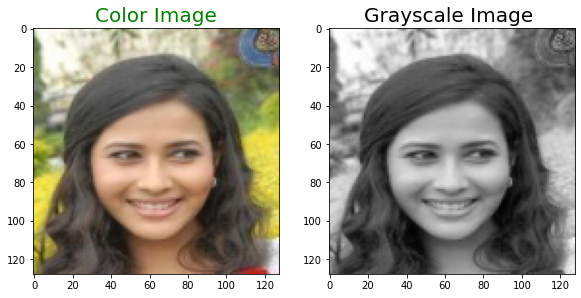

In [44]:
for idx in range(10):
  plot_images(color_images[idx], gray_images[idx])

#AutoEncoder

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

In [47]:
momentum = 0.9
alpha = 0.2

# Encoder
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", strides=2, input_shape=(128, 128, 1)))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", strides=2))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", strides=2))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", strides=2))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", strides=2))
model.add(LeakyReLU(alpha=alpha, name="Encoder_Output"))



# Decoder
model.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, padding="same"))
model.add(LeakyReLU(alpha=alpha))
model.add(BatchNormalization(momentum=momentum))

model.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=1, padding="same"))
model.add(Activation("tanh", name="Decoder_Output"))

In [49]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                        

In [50]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
    ReduceLROnPlateau(verbose=1),
    ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]

In [ ]:
history = model.fit(
    train_generator,
    validation_data=test_generator, 
    epochs=EPOCHS,
    callbacks=callbacks)

In [96]:
from tensorflow.keras.models import load_model

model = load_model("/content/chkp/weights.33-0.01.hdf5", compile=True)

In [59]:
VAL_IMAGES_PATH = "/content/output/val/img_align_celeba"
val_images = os.listdir(VAL_IMAGES_PATH)
val_generator = ColorizationAutoEncoderDataGenerator(val_images,VAL_IMAGES_PATH, batch_size=BATCH_SIZE, input_size=IMAGE_SHAPE)

In [61]:
loss, accuracy = model.evaluate_generator(val_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [62]:
print("Loss: {}".format(loss))
print("Accuracy: {}".format(accuracy))

Loss: 0.005555759649723768
Accuracy: 0.7478436827659607


In [69]:
%matplotlib inline

In [94]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale, cmap="gray")
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
    
    plt.show()

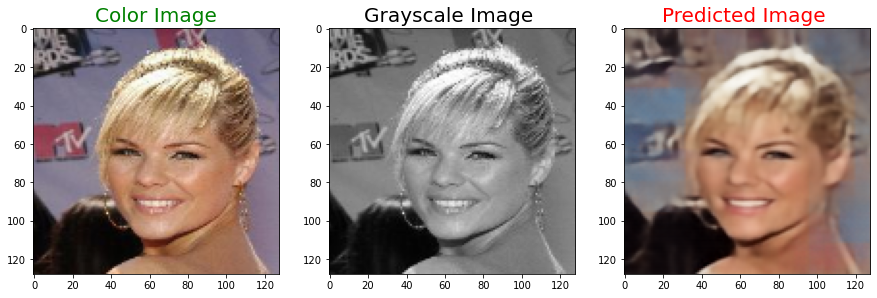

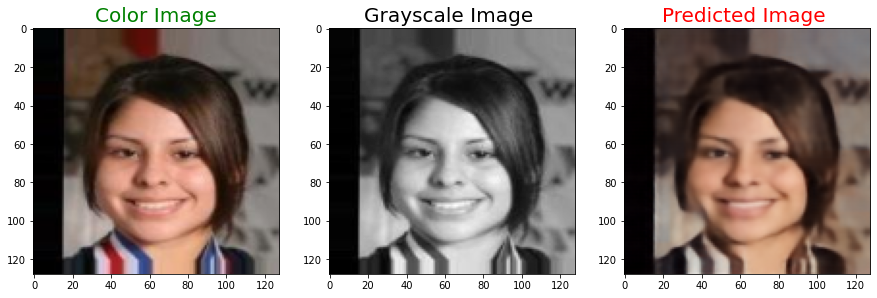

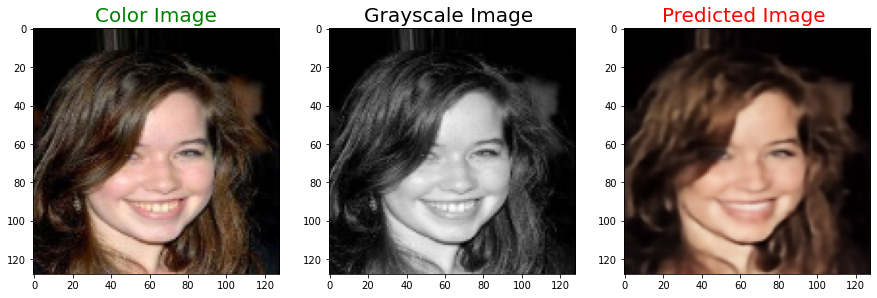

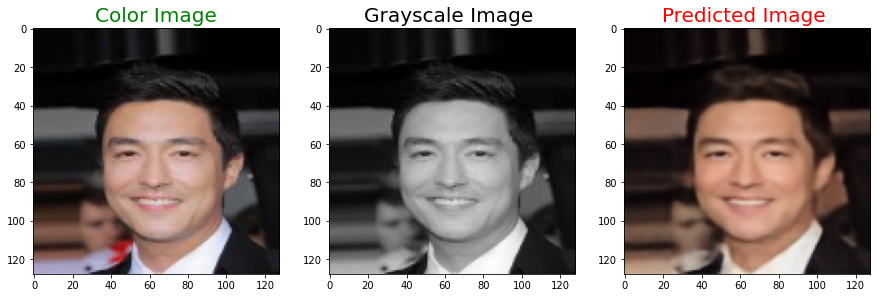

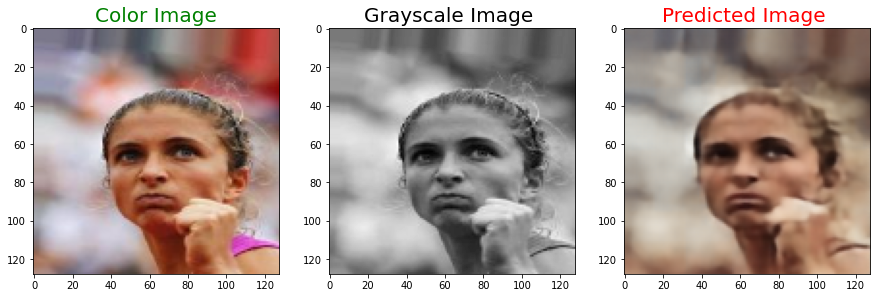

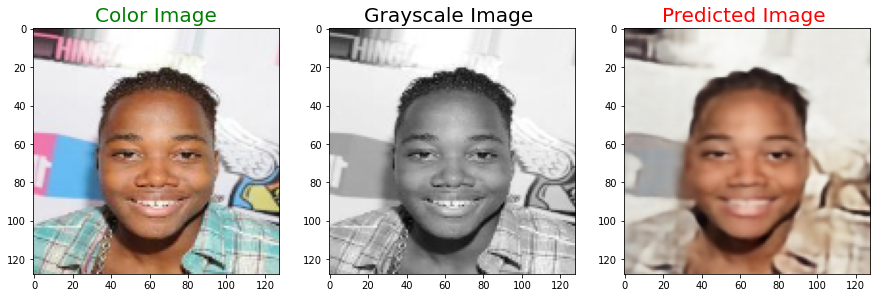

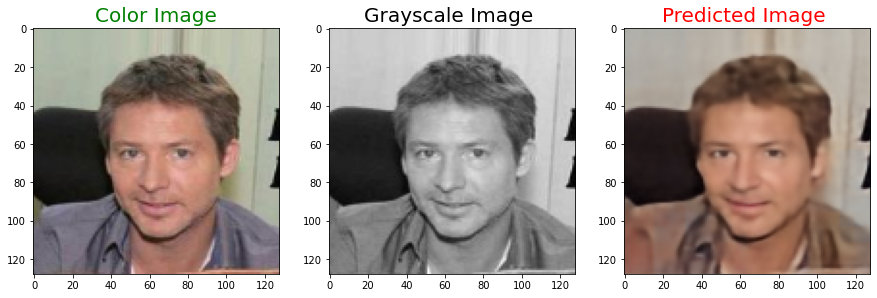

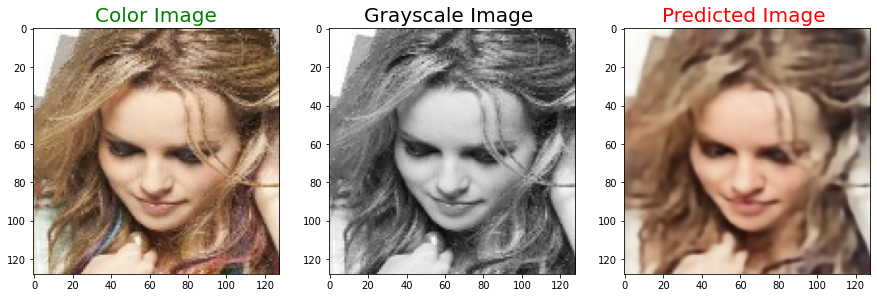

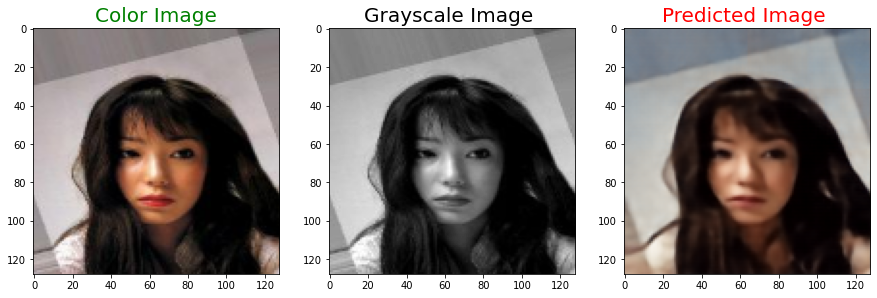

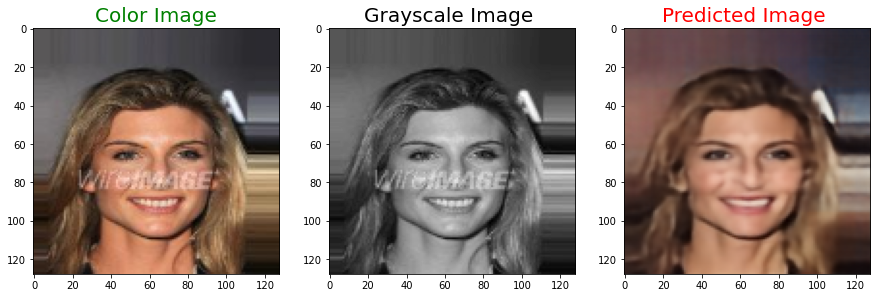

In [109]:
val_gray_images, val_color_images = next(val_generator)

for idx in range(10):
  grayscale = val_gray_images[idx].reshape((128, 128))
  color = val_color_images[idx]
  predicted = model.predict(val_gray_images[idx].reshape(-1, 128, 128, 1))
  predicted = np.clip(predicted , 0.0, 1.0)
  predicted_image = predicted.reshape(128, 128, 3)
  plot_images(color, grayscale, predicted_image)

#implemented By Muhammad Hanan Asghar